In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, recall_score

data=pd.read_csv('data/data.csv')

In [2]:
baseColumns = ['INCOME', 'SAVINGS', 'DEBT', 'R_SAVINGS_INCOME', 'R_DEBT_INCOME',
       'R_DEBT_SAVINGS', 'T_CLOTHING_12', 
       'R_CLOTHING_INCOME', 'R_CLOTHING_SAVINGS', 'R_CLOTHING_DEBT',
       'T_EDUCATION_12', 'R_EDUCATION_INCOME',
       'R_EDUCATION_SAVINGS', 'R_EDUCATION_DEBT', 'T_ENTERTAINMENT_12',
       'R_ENTERTAINMENT_INCOME',
       'R_ENTERTAINMENT_SAVINGS', 'R_ENTERTAINMENT_DEBT', 'T_FINES_12',
       'R_FINES_INCOME', 'R_FINES_SAVINGS',
       'R_FINES_DEBT', 'T_GAMBLING_12',
       'R_GAMBLING_INCOME', 'R_GAMBLING_SAVINGS', 'R_GAMBLING_DEBT',
       'T_GROCERIES_12', 'R_GROCERIES_INCOME',
       'R_GROCERIES_SAVINGS', 'R_GROCERIES_DEBT', 'T_HEALTH_12',
       'R_HEALTH_INCOME', 'R_HEALTH_SAVINGS', 'R_HEALTH_DEBT',
       'T_HOUSING_12', 'R_HOUSING_INCOME',
       'R_HOUSING_SAVINGS', 'R_HOUSING_DEBT', 'T_TAX_12',
       'R_TAX_INCOME', 'R_TAX_SAVINGS', 'R_TAX_DEBT', 'T_TRAVEL_12',
       'R_TRAVEL_INCOME', 'R_TRAVEL_SAVINGS',
       'R_TRAVEL_DEBT', 'T_UTILITIES_12', 'T_EXPENDITURE_12',
       'R_UTILITIES_INCOME', 'R_UTILITIES_SAVINGS', 'R_UTILITIES_DEBT',
       'R_EXPENDITURE_INCOME', 'R_EXPENDITURE_SAVINGS', 'R_EXPENDITURE_DEBT',
       'CAT_GAMBLING', 'CAT_DEBT', 'CAT_CREDIT_CARD', 'CAT_MORTGAGE',
       'CAT_SAVINGS_ACCOUNT', 'CAT_DEPENDENTS']
le = LabelEncoder()
data['CAT_GAMBLING'] = le.fit_transform(data['CAT_GAMBLING'])
data_crop=data.drop(["DEFAULT","CREDIT_SCORE","CUST_ID"],axis=1)

X= data_crop[baseColumns]
y = np.array(data['DEFAULT'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

In [3]:
def transform(X):
        for column in X.columns:
            if column == 'SAVINGS':
                X.loc[X[column] > 2500000, column] = 2500000
            elif column == 'DEBT':
                X.loc[X[column] > 4000000, column] = 4000000
            elif column == 'T_CLOTHING_12':
                X.loc[X[column] > 32000, column] = 32000
            elif column == 'T_HEALTH_12':
                X.loc[X[column] > 25000, column] = 25000
            elif column == 'T_TRAVEL_12':
                X.loc[X[column] > 150000, column] = 150000
        return X

X_train=transform(X_train)

In [4]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

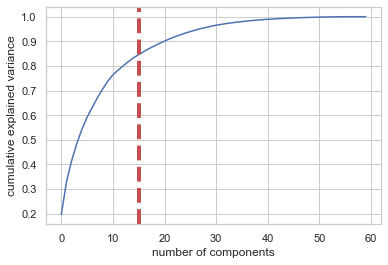

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.197058,0.197058
1,0.329432,0.132374
2,0.415368,0.085936
3,0.484839,0.069472
4,0.543325,0.058486
5,0.592275,0.048950
6,0.632102,0.039826
7,0.670738,0.038636
8,0.705978,0.035240
9,0.738230,0.032251


In [5]:
pca_test = PCA(n_components=60)
pca_test.fit(X_train_scaled)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=15, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

In [6]:
pca = PCA(n_components=15)
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [7]:
rfc_2 = RandomForestClassifier()
rfc_2.fit(X_train_scaled_pca, y_train)

RandomForestClassifier()

In [8]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
class_weight = [None, "balanced", "balanced_subsample"]


param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight': class_weight}
rs = RandomizedSearchCV(rfc_2, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train_scaled_pca, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 200,
 'min_samples_split': 34,
 'min_samples_leaf': 12,
 'max_features': 'sqrt',
 'max_depth': 6,
 'class_weight': None,
 'bootstrap': False}